In [1]:
%load_ext autoreload
%autoreload 2


In [2]:
import yt
from yt.units import dimensions
from yt.visualization.fixed_resolution import FixedResolutionBuffer

from modules import *
from sim import *
from read_ramses import *


In [56]:
# choose simulation
sim_round = 8
sim_name = "bturbfunc"
sim_dir = move_to_sim_dir(sim_round, sim_name)
print()

dump = get_dump(a_exp=0.1)
info = get_info(dump)

print("Dump: %d" % dump)
print("a_exp: %.3g" % info.a_exp)
print("Maximum AMR level: %d" % info.amr_level_max)


Moving to directory '/home/za9132/scratch/romain/round8/bturbfunc'.

Dump: 11
a_exp: 0.0653
Maximum AMR level: 13


In [57]:
use_cubic = False
use_override = False

halo_cat = get_halo_cat(dump, cgs=True)
biggest_halo_idx = np.argmax(halo_cat.mass)
biggest_halo_coord_mass = halo_cat.coord[:, biggest_halo_idx]
biggest_halo_coord_cubic = get_biggest_halo_coord_cubic(info.a_exp) * info.length_unit
biggest_halo_coord_override = np.array([0.51053163, 0.51277185, 0.49297882]) * info.length_unit

print("Halo coord (mass): (%.5g, %.5g, %.5g)" % tuple(biggest_halo_coord_mass / info.length_unit))
print("Halo coord (cubic): (%.5g, %.5g, %.5g)" % tuple(biggest_halo_coord_cubic / info.length_unit))

if use_override: 
    biggest_halo_coord = biggest_halo_coord_override
elif use_cubic:
    biggest_halo_coord = biggest_halo_coord_cubic
else:
    biggest_halo_coord = biggest_halo_coord_mass
    
biggest_halo_coord_code = biggest_halo_coord / info.length_unit


Halo coord (mass): (0.50763, 0.50888, 0.49572)
Halo coord (cubic): (0.50764, 0.50892, 0.49576)


In [58]:
info_file = os.path.join("output_%.5d" % dump, "info_%.5d.txt" % dump)
ds = yt.load(info_file)


yt : [INFO     ] 2023-12-15 10:20:22,217 Parameters: current_time              = 4.954672323431511
yt : [INFO     ] 2023-12-15 10:20:22,218 Parameters: domain_dimensions         = [128 128 128]
yt : [INFO     ] 2023-12-15 10:20:22,219 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2023-12-15 10:20:22,219 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2023-12-15 10:20:22,220 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2023-12-15 10:20:22,220 Parameters: current_redshift          = 14.307624008890196
yt : [INFO     ] 2023-12-15 10:20:22,220 Parameters: omega_lambda              = 0.723999977111816
yt : [INFO     ] 2023-12-15 10:20:22,220 Parameters: omega_matter              = 0.275999993085861
yt : [INFO     ] 2023-12-15 10:20:22,221 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2023-12-15 10:20:22,221 Parameters: hubble_constant           = 0.703000030517578


In [60]:
# define size and resolution of the region of interest

# tiny grid
# amr_level = 13
# box_size = 2 * const.kpc

# small grid
amr_level = 12
box_size = 5 * const.kpc

# medium grid
# amr_level = 10
# box_size = 20 * const.kpc

# large grid
# amr_level = 8
# box_size = 100 * const.kpc

left_edge = biggest_halo_coord - box_size / 2
N = int(box_size / info.length_unit * ds.domain_dimensions[0] * 2**amr_level)
lowres = 2**(info.amr_level_max - amr_level)

print("Grid size: %d" % N)
print("Lowres factor: %d" % lowres)


Grid size: 282
Lowres factor: 2


In [61]:
# get raw yt data from the region of interest

smooth_grid = True

if smooth_grid:
    data = ds.smoothed_covering_grid(level=amr_level, left_edge=(left_edge / info.length_unit), dims=[N]*3)
else:
    data = ds.covering_grid(level=amr_level, left_edge=(left_edge / info.length_unit), dims=[N]*3)


yt : [INFO     ] 2023-12-14 09:43:15,398 Adding particle_type: DM
yt : [INFO     ] 2023-12-14 09:43:15,408 Adding particle_type: star
yt : [INFO     ] 2023-12-14 09:43:15,417 Adding particle_type: cloud
yt : [INFO     ] 2023-12-14 09:43:15,427 Adding particle_type: dust
yt : [INFO     ] 2023-12-14 09:43:15,436 Adding particle_type: star_tracer
yt : [INFO     ] 2023-12-14 09:43:15,445 Adding particle_type: cloud_tracer
yt : [INFO     ] 2023-12-14 09:43:15,455 Adding particle_type: dust_tracer
yt : [INFO     ] 2023-12-14 09:43:15,465 Adding particle_type: gas_tracer


density max: [0.50738734 0.50860802 0.49582879]
star barycenter: [0.50738766 0.50860804 0.49582879]
dm barycenter: [0.5073805  0.50859445 0.49583633]


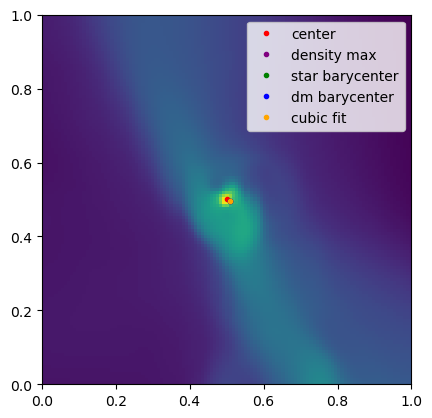

In [12]:
# quick look at the data

slice = X

particle_type = data["io", "particle_family"].value.astype(int)
is_dm = particle_type == DM
is_star = particle_type == STAR

coord_star_code = (np.array([data["io", "particle_position_x"].value[is_star], data["io", "particle_position_y"].value[is_star], data["io", "particle_position_z"].value[is_star]]))
mass_star_code = data["io", "particle_mass"][is_star].value

coord_dm_code = (np.array([data["io", "particle_position_x"].value[is_dm], data["io", "particle_position_y"].value[is_dm], data["io", "particle_position_z"].value[is_dm]]))
mass_dm_code = data["io", "particle_mass"][is_dm].value

coord_code = np.array([data["index", "x"].value, data["index", "y"].value, data["index", "z"].value])
density_code = data["ramses", "Density"].value

plt.imshow(np.log10(np.sum(density_code, axis=X)), extent=[0, 1, 0, 1], origin='lower')

x_idx, y_idx, z_idx = np.array(np.where(density_code == np.max(density_code))).T[0]
coord_code_density_max = coord_code[:, x_idx, y_idx, z_idx]
coord_code_star_barycenter = np.sum(coord_star_code * mass_star_code, axis=(1)) / np.sum(mass_star_code)
coord_code_dm_barycenter = np.sum(coord_dm_code * mass_dm_code, axis=(1)) / np.sum(mass_dm_code)

print("density max: %s" % coord_code_density_max)
print("star barycenter: %s" % coord_code_star_barycenter)
print("dm barycenter: %s" % coord_code_dm_barycenter)

plt.plot(0.5, 0.5, '.', color='red', label='center')
plt.plot(coord_code_density_max[Y], coord_code_density_max[Z], '.', color='purple', label='density max')
plt.plot(coord_code_star_barycenter[Y], coord_code_star_barycenter[Z], '.', color='green', label='star barycenter')
plt.plot(coord_code_star_barycenter[Y], coord_code_star_barycenter[Z], '.', color='blue', label='dm barycenter')
plt.plot(biggest_halo_coord_cubic[Y] / info.length_unit, biggest_halo_coord_cubic[Z] / info.length_unit, '.', color='orange', label='cubic fit')
plt.legend()


In [64]:
# read particle data from yt

particle_type = data["io", "particle_family"].value.astype(int)
is_dm = particle_type == DM
is_star = particle_type == STAR

coord_dm = (np.array([data["io", "particle_position_x"].value[is_dm], data["io", "particle_position_y"].value[is_dm], data["io", "particle_position_z"].value[is_dm]])) * info.length_unit - left_edge[:, None] - box_size / 2
mass_dm = data["io", "particle_mass"][is_dm] * info.mass_unit

coord_star = (np.array([data["io", "particle_position_x"].value[is_star], data["io", "particle_position_y"].value[is_star], data["io", "particle_position_z"].value[is_star]])) * info.length_unit - left_edge[:, None] - box_size / 2
mass_star = data["io", "particle_mass"][is_star].value * info.mass_unit
tau_starbirth = data["io", "conformal_birth_time"][is_star].value
id_star = data["io", "particle_identity"][is_star].value.astype(int)


In [65]:
# read gas data from yt

coord = (np.array([data["index", "x"].value, data["index", "y"].value, data["index", "z"].value])) * info.length_unit - left_edge[:, None, None, None] - box_size / 2
density = data["ramses", "Density"].value * info.density_unit
metallicity = data["ramses", "Metallicity"].value 
pressure = data["ramses", "Pressure"].value * info.energy_density_unit
energy_turb = data["ramses", "hydro_scalar_01"].value * info.vel_unit**2
ref_crit = data["ramses", "hydro_scalar_02"].value
b_turb = data["ramses", "hydro_scalar_03"].value
vel_vec = np.array([data["ramses", "x-velocity"].value, data["ramses", "y-velocity"].value, data["ramses", "z-velocity"].value]) * info.vel_unit


In [66]:
# compute local dx

dx_local = np.zeros((N, N, N))
for i, z in enumerate(coord_code[Z][0, 0, :]):
    sl = ds.slice(Z, z)
    bounds = (left_edge[X]/info.length_unit, (left_edge[X]+box_size)/info.length_unit, left_edge[Y]/info.length_unit, (left_edge[Y]+box_size)/info.length_unit)
    frb = FixedResolutionBuffer(sl, bounds, (N, N))
    dx_local[:, :, i] = frb["dx"]


NameError: name 'coord_code' is not defined

In [68]:
grid_name = "data_d%d_l%d_b%d" % (dump, lowres, int(box_size / const.kpc))
print("filename: %s.npz" % grid_name)

filename: data_d11_l2_b5.npz


In [71]:
safe_savez(
    grid_name,
    halo_idx=halo_cat.idx[biggest_halo_idx],
    halo_mass=halo_cat.mass[biggest_halo_idx],
    box_size=box_size,
    left_edge=left_edge,
    N=N,
    coord_dm=coord_dm,
    mass_dm=mass_dm,
    coord_star=coord_star,
    mass_star=mass_star,
    tau_starbirth=tau_starbirth,
    id_star=id_star,
    coord=coord,
    density=density,
    metallicity=metallicity,
    pressure=pressure,
    energy_turb=energy_turb,
    ref_crit=ref_crit,
    b_turb_loc=b_turb,
    vel_vec=vel_vec,
    lowres=lowres,
    dx_local=dx_local,
    **info.__dict__
)


File 'data_d11_l2_b5' already exists. Would you like to overwrite? [yes/no]: yes
Overwriting file.
